In [ ]:
# Wasnik, Riya
# 1001-163-569
# 2017-05-01
# Assignment_05_01

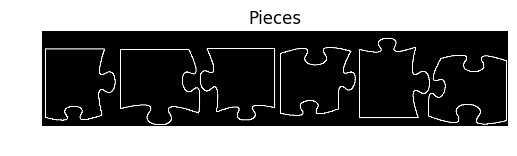

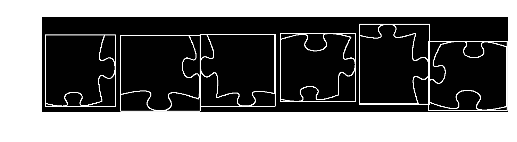

F:\Anaconda\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


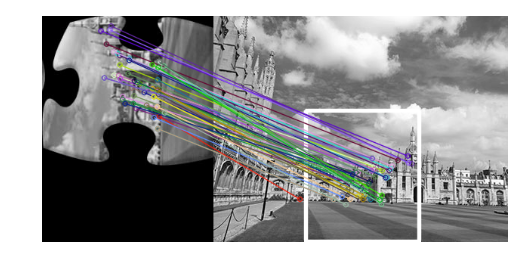

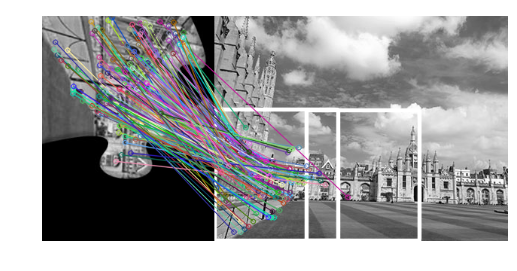

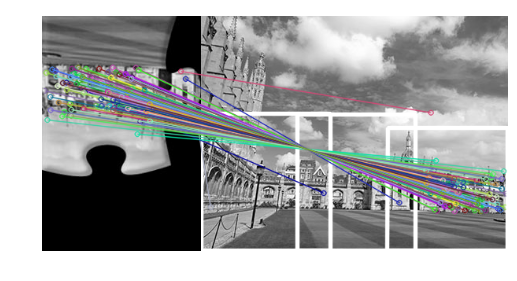

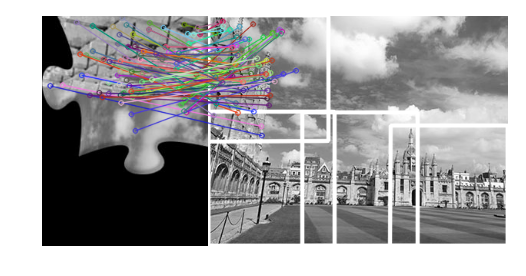

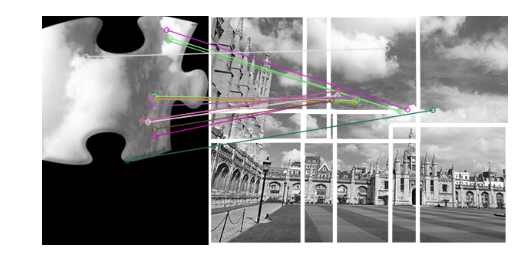

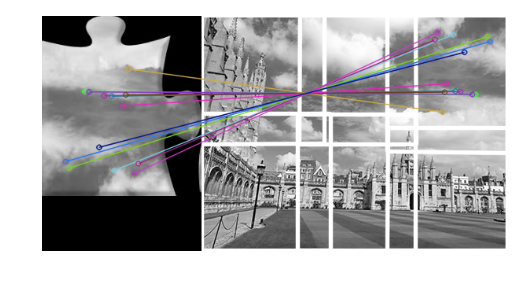

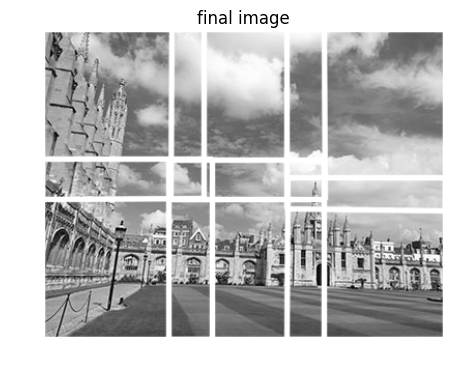

In [12]:
#Task1

from PIL import Image
import scipy
import glob
import numpy as np
import scipy.ndimage
import cv2
import skimage
#from skimage import img_as_ubyte
import matplotlib.pyplot as plt


complete_image = Image.open('picture.jpg')
complete_image=complete_image.convert('L')

complete_image= np.asarray(complete_image,dtype="uint8")/255.0 
complete_imagcopy =complete_image
im=Image.open('puzzlepieces.jpg') #Requires a black background

gray_im = im.convert('L')
gray_im = np.asarray(gray_im,dtype="uint8")/255.0

outh,outw = complete_image.shape
output_image = np.zeros((outh,outw))

binarized_image=np.zeros(gray_im.shape)
binarized_image[gray_im>0.06]=1.0
image=scipy.ndimage.morphology.binary_opening(binarized_image, 
                 structure=np.ones((3,3)), iterations=1, output=None, origin=0)
image=scipy.ndimage.morphology.binary_closing(image, 
             structure=np.ones((3,3)), iterations=1, output=None, origin=0)
#image[image>0.06]=1.0
cv_image = skimage.util.img_as_ubyte(image)
im2, contours, hierarchy = cv2.findContours(cv_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


#perimeter = cv2.arcLength(cnt,True)
cv2.drawContours(im2,contours,-1,(255,255,0),2)
plt.imshow(im2,cmap=plt.cm.gray)
plt.title("Pieces")
plt.axis('off')
plt.show()

#recon_img =np.zeros((h1,w1))
piece_array = []
for i in range(0,len(contours)):
        c =np.asarray(contours[i])
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(im2,(x,y),(x+w,y+h),(255,255,0),2)
        crop_img = gray_im[y:y+h, x:x+w] # Crop from x, y, w, h -> 100, 200, 300, 400
        #crop_img=np.asarray(crop_img,dtype="uint8")
        piece_array.append(crop_img)
plt.imshow(im2,cmap=plt.cm.gray)
plt.axis('off')
plt.show()


# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()
    
complete_imagcopy = skimage.util.img_as_ubyte(complete_imagcopy)
kp2, des2 = sift.detectAndCompute(complete_imagcopy,None)

bf = cv2.BFMatcher()
    
for v in piece_array:
#     plt.imshow(v)
#     plt.show()
    
    # find the keypoints and descriptors with SIFT
    v= skimage.util.img_as_ubyte(v)
    kp1, des1 = sift.detectAndCompute(v,None)
    matches = bf.knnMatch(des1, des2, k=2)
    #matches = flann.knnMatch(des1,des2,k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    
    MIN_MATCH_COUNT = 10

    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()

        h,w = v.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)

        complete_imagcopy = cv2.polylines(complete_imagcopy,[np.int32(dst)],True,255,3, cv2.LINE_AA)

    else:
        matchesMask = None
    draw_params = dict(matchColor = (0,255,0),singlePointColor = None,matchesMask = matchesMask, 
                   flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    #img3 = cv2.drawMatches(complete_imagcopy,kp1,v,kp2,good,None,**draw_params)
    img3 = cv2.drawMatches(v,kp1,complete_imagcopy,kp2,good,None,flags=2)
    
    #img3 = cv2.drawMatches(v,kp1,complete_imagcopy,kp2,good,None,**draw_params)
    plt.imshow(img3)
    plt.axis('off')
    plt.show()

plt.imshow(complete_imagcopy,cmap = 'gray')
plt.title("final image")
plt.axis('off')
plt.show()